# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4296.933994,0.9999,-131.886217,2112.01,1980.123783
OMUSDT,526.319895,1807.371193,0.4206,0.000000,1281.05,1281.050000
BTCUSDT,601.021649,856.330667,0.1993,3.537078,255.31,258.847078
JASMYUSDT,387.458505,734.056706,0.1708,0.000000,346.60,346.600000
SOLUSDT,281.200518,425.856891,0.0991,0.000000,144.66,144.660000
ETHUSDT,250.747339,264.663782,0.0616,0.000000,13.92,13.920000
TRXUSDT,76.868953,155.664044,0.0362,-10.723889,78.80,68.076111
BBUSDT,60.176053,51.768503,0.0120,-39.733101,-8.41,-48.143101
BNBUSDT,1.142121,1.222203,0.0003,-10.606040,0.08,-10.526040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-11-30    1400.498824
2024-12-01    1387.700221
2024-12-02    1418.524583
2024-12-03    1806.096259
2024-12-04    1729.714053
Name: Total, Length: 73, dtype: float64

In [24]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

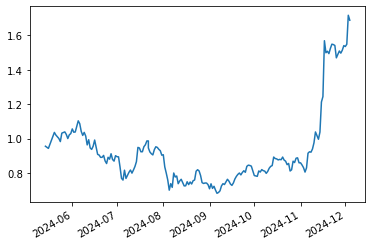

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MANAUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3575
BNBUSDT,0.1411
TRXUSDT,0.1312
XLMUSDT,0.0956
PEPEUSDT,0.0954
SUIUSDT,0.0754
JASMYUSDT,0.0720
XRPUSDT,0.0318
HBARUSDT,0.0000
WBTCUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.340370
BTCUSDT,0.300000
TRXUSDT,0.116027
XLMUSDT,0.069436
JASMYUSDT,0.062502
PEPEUSDT,0.059185
SUIUSDT,0.052481


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.356648
BTCUSDT,0.293481
TRXUSDT,0.257976
JASMYUSDT,0.091895


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1807.371193,0.420619,0.356648,0.063971
BTCUSDT,856.330667,0.199289,0.293481,-0.094192
JASMYUSDT,734.056706,0.170833,0.091895,0.078938
SOLUSDT,425.856891,0.099107,0.000000,0.000000
ETHUSDT,264.663782,0.061594,0.000000,0.000000
TRXUSDT,155.664044,0.036227,0.257976,-0.221749
BBUSDT,51.768503,0.012048,0.000000,0.000000
BNBUSDT,1.222203,0.000284,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1807.371193,0.420619,0.340370,0.080249
BTCUSDT,856.330667,0.199289,0.300000,-0.100711
JASMYUSDT,734.056706,0.170833,0.062502,0.108331
SOLUSDT,425.856891,0.099107,0.000000,0.000000
ETHUSDT,264.663782,0.061594,0.000000,0.000000
TRXUSDT,155.664044,0.036227,0.116027,-0.079800
BBUSDT,51.768503,0.012048,0.000000,0.000000
BNBUSDT,1.222203,0.000284,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.059185,-0.059185
XLMUSDT,0.000000,0.000000,0.069436,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

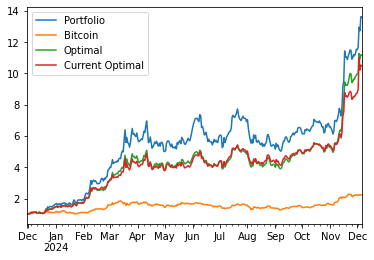

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

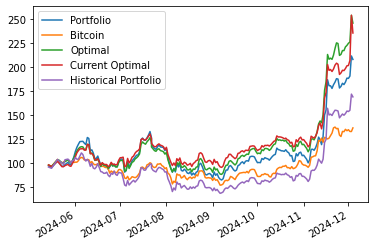

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-25,178.065991,128.947631,212.036627,192.199934,146.949156
2024-11-26,179.719985,127.490870,213.138457,193.774622,148.874744
2024-11-27,182.978786,132.783198,217.106652,196.566902,150.943684
2024-11-28,181.643078,132.479326,217.060930,196.227573,149.674755
2024-11-29,184.244156,134.971167,220.904431,198.406703,151.414174
2024-11-30,188.371031,133.506331,222.491529,201.226067,154.042164
2024-12-01,188.074264,134.578273,224.703738,201.529682,153.524639
2024-12-02,190.538771,132.703379,225.975972,206.767187,154.867822
2024-12-03,211.469783,132.715937,253.876476,253.909648,171.684779
2024-12-04,207.820069,136.453406,245.724477,235.391210,168.792541


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.601032
 dtype: float64,
 0.601811750919569)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.639617
 dtype: float64,
 0.6396167391656737)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.704201
Bitcoin            0.435442
Optimal            0.601812
Current Optimal    0.603435
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44934352263488153

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.369226,0.300000,0.033208,0.143390,0.047117,0.096273
JASMYUSDT,0.247673,0.062502,0.015391,0.053809,0.013361,0.040448
OMUSDT,17.804674,0.340370,0.900391,0.630468,0.524943,0.105525
PEPEUSDT,0.313943,0.059185,0.018515,0.062187,0.015570,0.046617
SUIUSDT,0.142144,0.052481,0.009658,0.035516,0.006928,0.028588
TRXUSDT,0.156087,0.116027,0.013503,0.042627,0.017060,0.025567
XLMUSDT,0.118655,0.069436,0.009333,0.032002,0.007731,0.024271


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.932958,0.356648,0.535480,0.562880,0.447091,0.115789
BTCUSDT,0.127595,0.293481,0.174842,0.116591,0.045524,0.071067
JASMYUSDT,0.092872,0.091895,0.076720,0.097026,0.029957,0.067069
TRXUSDT,0.254893,0.257976,0.212957,0.223503,0.156254,0.067249


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.098681,0.42,0.623045,0.612889,0.488032,0.124858
BTCUSDT,0.086953,0.20,0.117723,0.081455,0.016641,0.064814
JASMYUSDT,0.171807,0.17,0.140228,0.181405,0.080694,0.100711
SOLUSDT,0.036354,0.10,0.055940,0.071055,0.010097,0.060958
ETHUSDT,0.008968,0.06,0.028295,0.028089,0.002594,0.025495
TRXUSDT,0.039522,0.04,0.032624,0.014673,0.002957,0.011716
BBUSDT,-0.004771,0.01,0.002145,0.010433,0.000391,0.010043


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04774655243557131, -0.0690794252346475)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04889824975233161, -0.06817438071313195)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.031156
BTCUSDT     -0.001867
JASMYUSDT   -0.009440
SOLUSDT     -0.003077
ETHUSDT     -0.001657
TRXUSDT     -0.000573
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049016
Name: 2024-07-22 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.037222
BTCUSDT     -0.006825
JASMYUSDT   -0.013885
SOLUSDT     -0.006599
ETHUSDT     -0.002236
TRXUSDT     -0.000657
BBUSDT      -0.000752
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068174
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06235734988283024, -0.07992488169740045)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.066274553021148, -0.08494565307403873)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.056080487145831415, -0.06976102596260364)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06024890715332577, -0.07774502559954687)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.034905
BTCUSDT     -0.005380
JASMYUSDT   -0.012759
SOLUSDT     -0.004559
ETHUSDT     -0.001899
TRXUSDT     -0.000639
BBUSDT      -0.000823
Portfolio   -0.060963
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05539891954973331, -0.07160637718191153)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060686902369692194, -0.0768512122567314)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.036540
BTCUSDT     -0.005170
JASMYUSDT   -0.011767
SOLUSDT     -0.004355
ETHUSDT     -0.001727
TRXUSDT     -0.000712
BBUSDT      -0.000713
Portfolio   -0.060985
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05504598645058833, -0.0712420620253706)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06312199167541183, -0.08090215816994036)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039076
BTCUSDT     -0.005334
JASMYUSDT   -0.009773
SOLUSDT     -0.004652
ETHUSDT     -0.001979
TRXUSDT     -0.000653
BBUSDT      -0.000695
Portfolio   -0.062163
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10133386059054122, -0.14635862598861588)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10252507361930029, -0.1456602376369263)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.089993
BTCUSDT     -0.001366
JASMYUSDT   -0.012385
SOLUSDT     -0.002024
ETHUSDT      0.000208
TRXUSDT     -0.000226
BBUSDT      -0.000161
Portfolio   -0.105947
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06349096349655531, -0.07891207465467144)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06897012462343556, -0.08650009784973058)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.041272
BTCUSDT     -0.005869
JASMYUSDT   -0.012476
SOLUSDT     -0.004546
ETHUSDT     -0.001920
TRXUSDT     -0.001051
BBUSDT      -0.000707
Portfolio   -0.067840
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.052102,-0.087800,-0.074461,-0.025916
2024-01-15,-0.052102,-0.087801,-0.077464,0.013255
2024-01-16,-0.052102,-0.087709,-0.074411,0.039601
2024-01-17,-0.052102,-0.089150,-0.078910,-0.025034
2024-01-18,-0.052102,-0.091721,-0.080773,-0.037868
...,...,...,...,...
2024-12-02,-0.048045,-0.110857,-0.085305,0.005662
2024-12-03,-0.048045,-0.117171,-0.091705,0.123467
2024-12-04,-0.048592,-0.117348,-0.092408,-0.032110
2024-12-05,-0.048592,-0.117351,-0.089684,0.025913


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034621,-0.085353,-0.079641,-0.018455
2024-05-29,-0.034621,-0.082622,-0.076967,-0.008650
2024-05-30,-0.034621,-0.073417,-0.068834,0.045231
2024-05-31,-0.034621,-0.074550,-0.065230,0.040742
2024-06-01,-0.034621,-0.078092,-0.066147,0.053210
...,...,...,...,...
2024-12-02,-0.047457,-0.049075,-0.047147,0.013104
2024-12-03,-0.044872,-0.076999,-0.067379,0.109852
2024-12-04,-0.045153,-0.078636,-0.069862,-0.017259
2024-12-05,-0.045153,-0.084675,-0.069476,0.070666


<AxesSubplot:>

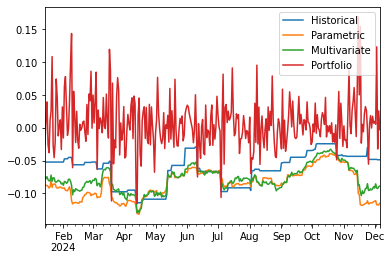

In [80]:
var_data.plot()

<AxesSubplot:>

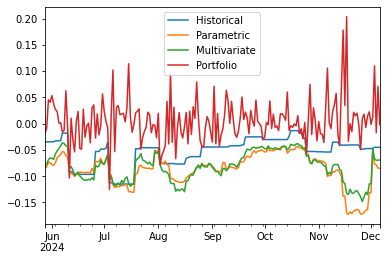

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02439,0.012195,0.012195
Kupiec Stat,5.539,13.999139,13.999139
P-value,0.018597,0.000183,0.000183


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.062176,0.015544,0.015544
Kupiec Stat,0.561019,6.528254,6.528254
P-value,0.45385,0.010617,0.010617


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77222832, 0.07636126, 0.05613996, 0.05523638, 0.04003408])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014937
ADAUSDT     0.015215
ALGOUSDT    0.017239
APTUSDT     0.015795
ARBUSDT     0.016625
              ...   
WBTCUSDT    0.009621
WLDUSDT     0.021876
XLMUSDT     0.012187
XRPUSDT     0.010549
XTZUSDT     0.016057
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

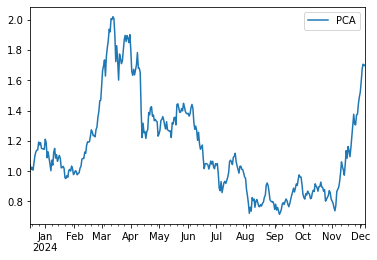

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

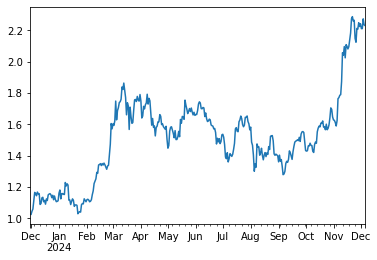

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.399411
EGLDUSDT     0.413361
WBETHUSDT    0.421060
ETHUSDT      0.421199
               ...   
FLOKIUSDT    1.111205
BONKUSDT     1.121005
WLDUSDT      1.126636
PEPEUSDT     1.155031
OMUSDT       1.524503
Length: 64, dtype: float64

<AxesSubplot:>

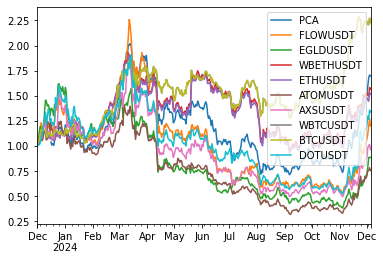

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

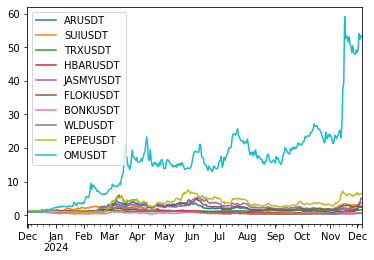

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52998602, 0.15270857, 0.13507611, 0.1053695 , 0.07685979])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.101601
BTCUSDT      0.062970
JASMYUSDT    0.165446
SOLUSDT      0.102898
ETHUSDT      0.083731
TRXUSDT      0.040832
BBUSDT       0.212815
BNBUSDT      0.067022
PEPEUSDT     0.162685
Name: PC1, dtype: float64

<AxesSubplot:>

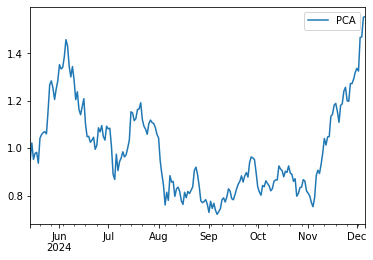

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

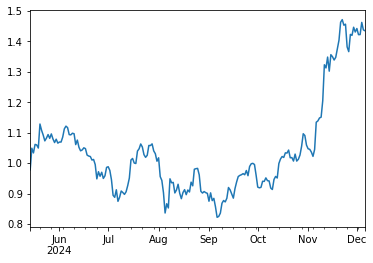

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.380437
ETHUSDT      0.395537
BNBUSDT      0.408356
BTCUSDT      0.413447
JASMYUSDT    0.624500
PEPEUSDT     0.669961
BBUSDT       0.704539
OMUSDT       0.863166
TRXUSDT      0.880153
dtype: float64

<AxesSubplot:>

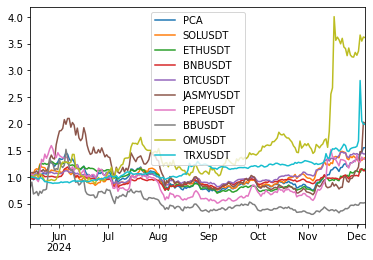

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.910441
BBUSDT       1.518567
JASMYUSDT    1.228158
SOLUSDT      1.142159
BTCUSDT      1.000000
ETHUSDT      0.947207
OMUSDT       0.873968
BNBUSDT      0.653605
TRXUSDT      0.236919
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.871785
BTCUSDT      1.000000
SOLUSDT      0.986189
BNBUSDT      0.799524
ETHUSDT      0.799321
BBUSDT       0.514295
JASMYUSDT   -0.152783
OMUSDT      -0.199183
TRXUSDT     -0.457245
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table

,Beta
OMUSDT,0.061890
BTCUSDT,0.750913
JASMYUSDT,0.144304
SOLUSDT,-0.378829
ETHUSDT,0.309248
TRXUSDT,0.044897
BBUSDT,0.284991
BNBUSDT,-0.090669
PEPEUSDT,-0.018302


In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.5539315885700652

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.211092
BTCUSDT      1.200617
JASMYUSDT    0.400028
SOLUSDT      0.752658
ETHUSDT      0.913461
TRXUSDT      0.144283
BBUSDT       0.327935
BNBUSDT      1.058595
PEPEUSDT     0.368033
PCA          1.000000
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.132774
BTCUSDT      0.839479
JASMYUSDT    0.067084
SOLUSDT      0.456790
ETHUSDT      0.129899
TRXUSDT      0.054346
BBUSDT       0.335807
BNBUSDT      0.469636
PEPEUSDT     0.149133
PCA          1.000000
dtype: float64

In [104]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.297071,0.156687,0.353855,0.227589,0.131055,0.267591,0.206985,0.169961
BTCUSDT,0.297071,1.000000,0.480497,0.704651,0.789435,0.152277,0.552182,0.595951,0.655648
JASMYUSDT,0.156687,0.480497,1.000000,0.457797,0.472817,0.235703,0.553602,0.445770,0.375564
SOLUSDT,0.353855,0.704651,0.457797,1.000000,0.654826,0.175431,0.547421,0.508980,0.542405
ETHUSDT,0.227589,0.789435,0.472817,0.654826,1.000000,0.124545,0.601310,0.584589,0.643980
TRXUSDT,0.131055,0.152277,0.235703,0.175431,0.124545,1.000000,0.131388,0.298792,0.098122
BBUSDT,0.267591,0.552182,0.553602,0.547421,0.601310,0.131388,1.000000,0.577975,0.473018
BNBUSDT,0.206985,0.595951,0.445770,0.508980,0.584589,0.298792,0.577975,1.000000,0.417388
PEPEUSDT,0.169961,0.655648,0.375564,0.542405,0.643980,0.098122,0.473018,0.417388,1.000000


In [105]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.116736,0.301813,0.246362,-0.540956,0.688222,0.244794,0.321037,-0.366130
BTCUSDT,-0.116736,1.000000,-0.026942,0.659463,0.526993,-0.050787,0.273969,0.432629,0.797520
JASMYUSDT,0.301813,-0.026942,1.000000,0.537292,-0.067241,0.429542,0.244636,0.329609,-0.076393
SOLUSDT,0.246362,0.659463,0.537292,1.000000,0.203051,0.395121,0.436145,0.554736,0.499201
ETHUSDT,-0.540956,0.526993,-0.067241,0.203051,1.000000,-0.267785,0.291716,0.203864,0.570296
TRXUSDT,0.688222,-0.050787,0.429542,0.395121,-0.267785,1.000000,0.519492,0.779943,-0.170306
BBUSDT,0.244794,0.273969,0.244636,0.436145,0.291716,0.519492,1.000000,0.640930,0.014744
BNBUSDT,0.321037,0.432629,0.329609,0.554736,0.203864,0.779943,0.640930,1.000000,0.305211
PEPEUSDT,-0.366130,0.797520,-0.076393,0.499201,0.570296,-0.170306,0.014744,0.305211,1.000000


## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05-30,0.000001,0.000001,0.000001,0.000001,0.000001,0.044298,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
2024-06-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.612079,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-07-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.569874,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.137604,0.000000
2024-08-28,0.214278,0.025984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.759738,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-09-27,0.044646,0.004536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-10-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.690688,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-11-26,0.000000,0.113959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.109206,0.192871,0.000000
2024-12-06,0.000000,0.000022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.031253,0.055974,0.001796,0.000000


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

TIAUSDT     0.413661
LTCUSDT     0.226433
NEARUSDT    0.144353
SUIUSDT     0.089712
XLMUSDT     0.055974
              ...   
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
IMXUSDT     0.000000
XTZUSDT     0.000000
Name: 2024-12-06 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

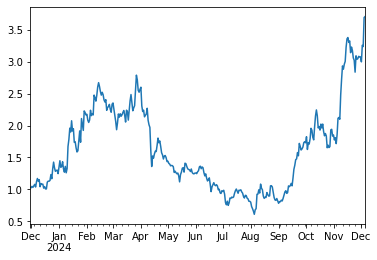

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()